In [24]:
import pandas as pd
from collections import defaultdict
import numpy as np

In [120]:
def postprocessing_features(raw_features,parallelism=8000):
    raw_features = np.array(raw_features)
    output=np.zeros(33)
    if parallelism>1000:
        mem_band=208*10**9 #st4 cluster
    else:
        mem_band=689*10**9
    output[0:4]=raw_features[0:4]/mem_band
    output[4:7]=raw_features[4:7]/raw_features[24]
    output[7:10]=raw_features[7:10]/raw_features[25]
    output[10]=raw_features[10]/raw_features[24]
    output[11]=raw_features[11]/raw_features[25]
    output[12]=raw_features[12]/parallelism
    # output[12]=raw_features[12]/raw_features[24]
    # output[13]=raw_features[12]/raw_features[25]
    # output[14]=raw_features[13]/raw_features[24]
    # output[15]=raw_features[13]/raw_features[25]
    output[15]=raw_features[13]/parallelism
    output[16:20]=raw_features[14:18]/mem_band
    output[20:24]=raw_features[[19,20,22,23]]/mem_band
    # output[24:26]=raw_features[[18,21]]/raw_features[24]
    output[26:28]=raw_features[[18,21]]/parallelism
    # output[26:28]=raw_features[[18,21]]/raw_features[25]
    output[28]=raw_features[24]/parallelism
    output[29]=raw_features[25]/parallelism
    output[30]=raw_features[24]/raw_features[25]
    output[31:33]=raw_features[26:28]
    return output

feature_names = ["mem_mat_read",    # 0: materialization(MA) memory read / memory bandwidth
                 "mem_mat_write",   # 1: MA memory write / memory bandiwidth
                 "mem_fac_read",    # 2: factorization(FA) memory read / memory bandwidth
                 "mem_fac_write",   # 3: FA memory write / memory bandwidth
                 "comp_scalar_mat", # 4: scalar ops complexity in MA / total MA complexity
                 "comp_lmm_mat",    # 5: LMM ops complexity in MA / total MA complexity
                 "comp_rmm_mat",    # 6: RMM ops complexity in MA / total MA complexity
                 "comp_scalar_fac", # 7: scalar ops complexity in FA / total MA complexity
                 "comp_lmm_fac",    # 8: LMM ops complexity in FA / total FA complexity
                 "comp_rmm_fac",    # 9: RMM ops complexity in FA / total FA complexity
                 "comp_mat_col_major",  # 10: Column-major access ops complexity in MA / total MA complexity
                 "comp_fac_col_major",  # 11: Column-major access ops complexity in FA / total FA complexity
                 "comp_scalar_dense",   # 12: dense scalar ops complexity / parallelism
                 "13",
                 "14",
                 "comp_matrix_dense",   # 15: dense matrix multiplication complexity / paralellism
                 "mem_read_scalar_dense",   # 16: dense scalar ops memory read / memory bandwidth
                 "mem_write_scalar_dense",  # 17: dense scalar ops memory write / memory bandwidth
                 "mem_read_matrix_dense",   # 18: dense MM memory read / memory bandwidth
                 "mem_write_matrix_dense",  # 19: dense MM memory write / memory bandwidth
                 "mem_read_rowsum", # 20: Rowsum ops memory read / memory bandwidth
                 "mem_write_rowsum",# 21: Rowsum ops memory write / memory bandiwdth
                 "mem_read_colsum", # 22: Colsum ops memory read / memory bandwidth
                 "mem_write_colsum",# 23: Colsum ops memory write / memory bandwidth
                 "24",
                 "25",
                 "comp_rowsum",     # 26: Rowsum ops complexity / parallelism
                 "comp_colsum",     # 27: Colsum ops complexity / parallelism
                 "comp_mat",        # 28: total MA complexity / parallelism
                 "comp_fac",        # 29: total FA complexity / parallelism
                 "comp_ratio",      # 30: complexity ratio
                 "tr",          # 31: Morpheous TR
                 "fr"           # 32: Morpheous FR
                 ]

In [175]:
model_operators = ["Linear Regression", "Gaussian" , "Logistic Regression", "KMeans"]

def read_and_join(suffix: str = ""):
    res = pd.read_parquet(f"./results/sigmod_merged{suffix}.parquet")
    features = pd.read_parquet(f"./results/sigmod_merged_features{suffix}.parquet")
    res = res[res.operator.isin(model_operators)]
    res.reset_index(drop=True, inplace=True)
    res = res.merge(pd.json_normalize(res.data_characteristics), left_index=True, right_index=True)
    features = features[features.operator.isin(model_operators)]
    pre = res.copy()
    # materialized complexities

    materialized_complexity_dict = defaultdict(lambda: 0)
    for dataset, operator, complexity in res[res.model == 'materialized'][['dataset', 'operator', 'complexity']].values:
        materialized_complexity_dict[(dataset, operator)] = complexity

    def calc_complexity_ratio(row):
        if row[1] == 'Materialization':
            return None
        val = materialized_complexity_dict[(row[0], row[1])]
        if not val:
            return None
        return  val/ row[2]

    res['complexity_ratio'] = res[['dataset', 'operator', 'complexity']].apply(calc_complexity_ratio, axis=1)

    baseline_lookup_dict = {(dataset, operator, num_cores): mean_time for (dataset, operator, num_cores, mean_time) in res[((res.model == 'materialized') | (res.model == 'baseline'))][['dataset', 'operator', 'num_cores', 'times_mean']].values}
    def calc_speedup(row) -> float:
        if row[1] == 'Materialization':
            return 0.0
        baseline = baseline_lookup_dict[(row[0], row[1], row[2])]
        return baseline / row[3]


    res['speedup'] = res[['dataset', 'operator', 'num_cores', 'times_mean']].apply(calc_speedup, axis=1)
    res = res[res.model == 'factorized'][['dataset', 'speedup', 'operator', 'num_cores',
                                          "selectivity", "cardinality_T", "cardinality_S",
                                          # 'r_T', 'c_T', 'r_S', 'c_S', 'Snonzero', 'Tnonzero'
                                          ]]
    # turn res into: dataset, speedup, for models only
    # single sample = dataset, ML model, [features], speedup
    # res left join features on dataset, operator
    #     apply postprocessing_features

    # TODO include r_T=100000 features
    res = pd.merge(res, features[['dataset', 'operator', 'features']], how='right', on=['dataset', 'operator'])
    res['parallelism'] = res.num_cores * 1000
    res['processed_features'] = res[['features', 'parallelism']].apply(lambda row: postprocessing_features(*row), axis=1)
    res[feature_names] = pd.DataFrame(res.processed_features.tolist(), index=res.index)
    res = res.drop(columns=["features", "parallelism", "processed_features"])
    res['label'] = res.speedup > 1.
    return res


sigmod = read_and_join()
hamlet = read_and_join("_hamlet")

In [177]:
model_features = ["operator", "num_cores",
                  # "r_T", "c_T", "r_S", "c_S", "Snonzero", "Tnonzero",
                  "selectivity", "cardinality_T", "cardinality_S",
                  "fr", "tr", "comp_ratio",
        "mem_write_rowsum", "comp_lmm_fac", "comp_scalar_dense", "comp_lmm_mat"]
X = sigmod[model_features]

In [160]:
X

,operator,num_cores,fr,tr,comp_ratio,mem_write_rowsum,comp_lmm_fac,comp_scalar_dense,comp_lmm_mat
0,Linear Regression,16,10.000000,18.571482,1.607358,0.000000,0.960795,62.501250,0.975609
1,Linear Regression,32,10.000000,18.571482,1.607358,0.000000,0.960795,31.250625,0.975609
2,Linear Regression,8,10.000000,18.571482,1.607358,0.000000,0.960795,125.002500,0.975609
3,Linear Regression,24,10.000000,18.571482,1.607358,0.000000,0.960795,41.667500,0.975609
4,Gaussian,16,10.000000,18.571482,1.462350,0.000000,0.000000,125.001250,0.000000
...,...,...,...,...,...,...,...,...,...
19035,KMeans,24,1.666667,2.500000,0.814689,0.000115,0.911361,125.012500,0.889577
19036,Logistic Regression,32,1.666667,2.500000,0.799752,0.000000,0.977849,78.125000,0.972302
19037,Logistic Regression,8,1.666667,2.500000,0.799752,0.000000,0.977849,312.500000,0.972302
19038,Logistic Regression,16,1.666667,2.500000,0.799752,0.000000,0.977849,156.250000,0.972302


In [178]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def train_and_score(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    categorical_features = ["operator"]
    if 'num_cores' in X.columns:
        categorical_features.append("num_cores")

    numeric_features = [x for x in X.columns if x not in categorical_features]

    transformers = [
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(), categorical_features)
    ]

    preprocessor = ColumnTransformer(
        transformers=transformers
    )
    pipe = make_pipeline(preprocessor, model)
    pipe.fit(X_train, y_train)
    print(f"Model {model}")
    print(f"Score: {pipe.score(X_test, y_test)}")
    try:
        ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap='bone', text_kw={'size': 20})
    except Exception as e:
        ...
    return pipe


Model LogisticRegression(max_iter=1000)
Score: 0.9136904761904762


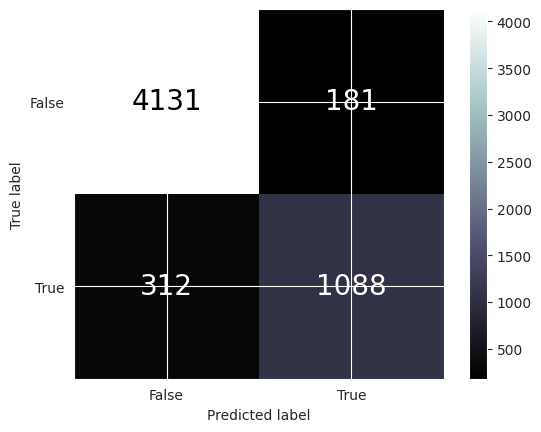

In [179]:
trained_pipe = train_and_score(LogisticRegression(max_iter=1000), X, sigmod.label)

Model Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['selectivity',
                                                   'cardinality_T',
                                                   'cardinality_S', 'fr', 'tr',
                                                   'comp_ratio',
                                                   'mem_write_rowsum',
                                                   'comp_lmm_fac',
                                                   'comp_scalar_dense',
                                                   'comp_lmm_mat']),
                                                 ('cat', OneHotEncoder(),
                                                  ['operator', 'num_cores'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])
Score: 0.8154761904761905


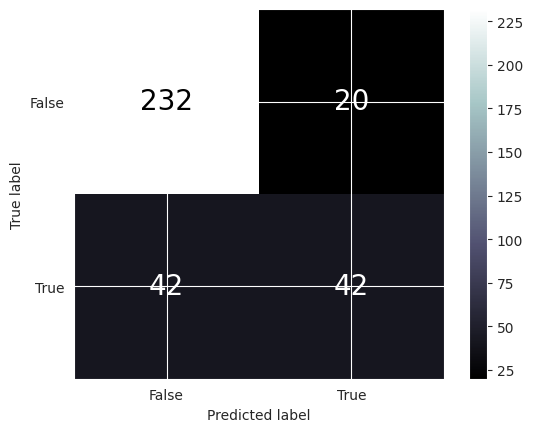

In [180]:
X_test = hamlet[model_features]
y_test = hamlet.label
print(f"Model {trained_pipe}")
print(f"Score: {trained_pipe.score(X_test, y_test)}")
ConfusionMatrixDisplay.from_estimator(trained_pipe, X_test, y_test, cmap='bone', text_kw={'size': 20})

In [234]:
class Morpheus:
    tuple_ratio = 5
    feature_ratio = 1

    @staticmethod
    def predict(X):
        res = []
        for fr, tr in X[['fr', 'tr']].values:
            res.append(Morpheus.optimize(fr, tr))
        return res

    @staticmethod
    def score(X, y):
        pred = Morpheus.predict(X)
        return np.count_nonzero(np.array(pred) != np.array(y)) / len(y)

    @staticmethod
    def optimize(t, f):
        return t > 5 and f > 1

class Amalur:
    complexity_ratio_boundary = 1.5

    @staticmethod
    def predict(X):
        res = []
        for c in X['comp_ratio'].values:
            res.append(Amalur.optimize(c))
        return res

    @staticmethod
    def score(X, y):
        pred = Amalur.predict(X)
        return np.count_nonzero((np.array(pred) != np.array(y))) / len(y)

    @staticmethod
    def optimize(c):
        return c > Amalur.complexity_ratio_boundary

In [232]:
Morpheus.score(X_test, y_test)

0.5357142857142857

In [235]:
Amalur.score(X_test, y_test)

0.4642857142857143